# Image Deblurring - June Exam



*  Marco Aspromonte 
*  Mat. 978241 
*  https://github.com/sustaz
* marco.aspromonte@studio.unibo.it

This is the notebook in which i want to solve the task of removing Gaussian blur from a set of images, so we need a good features extractor and denoiser. There are many models that are able to remove the noise from images, but since we are dealing with Gaussian noise, we will focus on Convolution and Convolution Transposed (also known as Deconvolution) based Neural Networks. In particular, i will show some results computed with a simple autoencoder architecture and with a REDNET one, that is the main model of the notebook.

### Dataset creation - DO NOT MODIFY

In [ ]:
import tensorflow as tf 
import random
from cv2 import GaussianBlur
import numpy as np
import matplotlib.pyplot as plt

def getDataset():
  (x_train, _), (x_test, _) = tf.keras.datasets.cifar10.load_data()
  normalize = lambda x: x/x.max()
  x_train = normalize(x_train)
  x_test = normalize(x_test)
  createBlurred = lambda arr: np.array([GaussianBlur(x, (5,5), ((random.random()*3)+1)) + (0.02*np.random.normal(0,1, (32, 32, 3))) for x in arr])
  return (createBlurred(x_train), x_train), (createBlurred(x_test), x_test)

### Global configuration and functions

Import Needed libraries

In [ ]:
from keras import backend as K
from tensorflow.keras.models import Model
from IPython.display import clear_output 
import keras
from tensorflow.keras import Model
from tensorflow.keras.layers import (Flatten, Dense, Input, MaxPooling2D,ReLU,
                                     Layer, Conv2D, Reshape,  Add,Conv2DTranspose
                                     ,BatchNormalization, concatenate,ELU)
import typing
import warnings
from keras.callbacks import ReduceLROnPlateau

warnings.filterwarnings('ignore')

TPU configuration (TPU performs better on the main model)

In [ ]:
import os
try:
  device_name = os.environ['COLAB_TPU_ADDR']
  TPU_ADDRESS = 'grpc://' + device_name
  print('Found TPU at: {}'.format(TPU_ADDRESS))

  resolver = tf.distribute.cluster_resolver.TPUClusterResolver(TPU_ADDRESS)
  tf.config.experimental_connect_to_cluster(resolver)
  tf.tpu.experimental.initialize_tpu_system(resolver)
  strategy = tf.distribute.experimental.TPUStrategy(resolver)
  print('TPU allocated!')

except KeyError:
  print('TPU not found')

TPU allocated!


Split the datas into train and test samples, from the training datas i will consider a slice of 1000 samples (0.5%) as the validation datas.

In [ ]:
(X_train, y_train), (X_test,y_test) = getDataset()

In [ ]:
val_size = 1000
train_size = (X_train.shape[0] - val_size)

print('Chosen size of the training set', train_size)
print('Chosen size of the validation set', val_size)
print('Chosen size of the test set', X_test.shape[0])

Chosen size of the training set 49000
Chosen size of the validation set 1000
Chosen size of the test set 10000


In [ ]:
X_val = X_train[train_size::]

y_val = y_train[train_size::]

X_train = X_train[0:train_size]
y_train = y_train [0:train_size]

print('Size of the training set', X_train.shape[0])
print('Size of the validation set', X_val.shape[0])
print('Size of the test set', X_test.shape[0])

Size of the training set 49000
Size of the validation set 1000
Size of the test set 10000


Enable data augmentation, if activated it requires a bit more computational time, but the models converge better in less epochs, prevent overfitting and is more robust during the training. In this case i decided to deploy the flipud and fliplr transformations.

In [ ]:
def apply_transform(x_data, y_data, T):
    N = x_data.shape[0]

    new_x_data = np.zeros_like(x_data)
    new_y_data = np.zeros_like(y_data)

    for i in range(N):
        new_x_data[i] = T(x_data[i])
        new_y_data[i] = T(y_data[i])
    return new_x_data, new_y_data

def augment_data(x_data: np.array, y_data: np.array, transforms: list) -> np.array:
    new_x_data = x_data
    new_y_data = y_data

    for T in transforms:
        new_x, new_y = apply_transform(x_data, y_data, T)

        new_x_data = np.concatenate([new_x_data, new_x], axis=0)
        new_y_data = np.concatenate([new_y_data, new_y], axis=0)
    return new_x_data, new_y_data

augment = True

if augment == True:
    # Augment our data with flipud and fliplr
    transforms = [np.flipud, np.fliplr]
    X_train, y_train = augment_data(X_train, y_train, transforms)
    X_val, y_val = augment_data(X_val, y_val, transforms)
    X_test, y_test = augment_data(X_test, y_test, transforms)
    print('Resize of the training set', X_train.shape[0])
    print('Resize of the validation set', X_val.shape[0])
    print('Resize of the test set', X_test.shape[0])


Resize of the training set 147000
Resize of the validation set 3000
Resize of the test set 30000


Just take a look to the samples

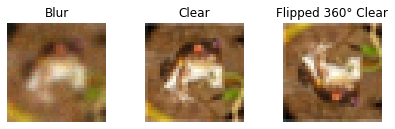

In [ ]:
fig = plt.figure(figsize=(7,4))
rows = 2
columns = 3
fig.add_subplot(rows, columns, 1)
plt.imshow(X_train[0])
plt.axis('off')
plt.title("Blur")
fig.add_subplot(rows, columns, 2)
plt.imshow(y_train[0])
plt.axis('off')
plt.title("Clear")

if augment == True:
  fig.add_subplot(rows, columns, 3)
  plt.imshow(y_train[49000])
  plt.axis('off')
  plt.title("Flipped 360° Clear")

Callback to save the weights

In [ ]:
%%script false
from google.colab import drive
drive.mount('/content/drive')

save = False
if save == True:
  checkpoint_path  = '/content/drive/MyDrive/deep/backup/autoencoder.h5'
  cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                  save_weights_only=True,
                                                  verbose=1)

Callback to reduce learning rate after some epochs. This can be useful to avoid the overfitting and improve the training phase.

In [ ]:
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               verbose=1,
                               min_lr=0.0001)

A function to plot the predicted results with respect to the ground truth and training blurred samples 

In [ ]:
def plot_results(blur, predicted, clear, index):
  fig = plt.figure(figsize=(7,4))
  rows = 2
  columns = 3
  fig.add_subplot(rows, columns, 1)
  plt.imshow(blur)
  plt.axis('off')
  if index == 0:
    plt.title("Blur")
  fig.add_subplot(rows, columns, 2)
  plt.imshow(predicted)
  plt.axis('off')
  if index == 0:
    plt.title("Predicted")
  fig.add_subplot(rows, columns, 3)
  plt.imshow(clear)
  plt.axis('off')
  if index == 0:
    plt.title("Clear")

A function to plot the metric's results

In [ ]:
def plot_metrics(history, loss, val_loss, name, x, y , legend):
  plt.figure(figsize=(10,5)) 
  plt.plot(history.history[loss])
  plt.plot(history.history[val_loss])
  plt.title(name)
  plt.ylabel(y)
  plt.xlabel(x)
  plt.legend(legend, loc='upper right')
  plt.grid()
  plt.show()

Variable for the shape of the input used for both the models. 

In [ ]:
input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])

### ***SIMPLE CONVOLUTIONAL AUTOENCODER***

Convolutional autoencoders are particular neural architectures in which the samples are first Convolved and symmetrically Deconvolved in order to extract features and remove the noise. This model is called simply **autoencoder**. Here we define two parameters, the dimension of the **latent space**, that is the **bottleneck** between the stack of convolutions and deconvolutions in which the information about features is compressed, and the filter dimension applied to each **pooled** sample. During the Encoder step the samples are scaled down with the **stride** parameter set to 2, during Decoder one their shape is restored.

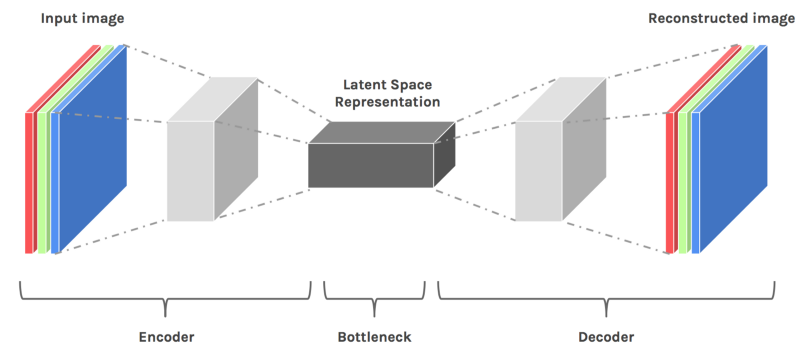

In [ ]:
latent_dim = 512
filter_dim = [32, 64, 128]

Define a function for encoder, in which we build a stack of 2 dimensional convolutions, setting three output filters of **64,128 and 256**. The chosen activation function is ELU followed by a BatchNormalization layer, in order to avoid the vanishing gradient and improve the robustness of the model.

In [ ]:
def encoder(inputs):
    
    x = inputs  

    for filter in filter_dim:
        x = Conv2D(filters=filter,
                  kernel_size=3,
                  strides=2,
                  padding='same')(x)

        x = ELU()(x)
        x = BatchNormalization()(x)

    shape = K.int_shape(x)
    x = Flatten()(x)
    latent = Dense(latent_dim)(x)

    return inputs, latent, shape

Define a function for **decoder**, symmetric with respect to the encoder. Since our samples are normalized in [0,1], the last layer has a **sigmoid** as activation function.

In [ ]:
def decoder(shape,latent_inputs):    

    x = Dense(shape[1]*shape[2]*shape[3])(latent_inputs)
    x = Reshape((shape[1], shape[2], shape[3]))(x)

    for filter in filter_dim[::-1]:

        x = Conv2DTranspose(filters=filter,
                            kernel_size=3,
                            strides=2,
                            padding='same')(x)

        x = ELU()(x)
        x = BatchNormalization()(x)

    outputs = Conv2DTranspose(filters=3,
                              kernel_size=3,
                              padding='same',activation = 'sigmoid')(x)

    return latent_inputs,outputs

Now we can compile the full encoder-decoder model, choosing **Adam** as optimizer and the mandatory **MSE loss function**. We consider also the **accuracy** as metric to check the confidence of the model about good predictions. 

In [ ]:
def build_autoencoder():
    inputs = Input(shape = input_shape, name = 'encoder_input')
    
    inputs, latent , shape = encoder(inputs)
    Encoder = Model(inputs, latent, name='encoder')

    latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
    latent_inputs,outputs = decoder( shape, latent_inputs)
    Decoder = Model(latent_inputs, outputs, name='decoder')

    autoencoder = Model(inputs, Decoder(Encoder(inputs)), name='autoencoder')
    autoencoder.compile(loss='mse', optimizer='adam',metrics=["acc"])

    return autoencoder, Encoder,Decoder

In [ ]:
try:
  with strategy.scope():

    autoencoder, encoder, decoder = build_autoencoder()
    print('TPU training')

except:

  autoencoder, encoder, decoder = build_autoencoder()
  print('GPU training')

TPU training


**We can now plot the model in order to check the correctness of the layers and if is there any disconnection.**

The encoder looks like this, we have three Convolutional layers in which we decrease the image into a 4x4x256 (that is the dimension of the Dense) to extract the features tuning the **stride** parameter with, then we addensate the information with a Dense layer into a one-dimensional latent vector,  that will be the input of the decoder in which the details of the samples are restored. 
The model is going to have a kernel size equal to 3, that is a conventional size. Strides will be 2 along height and width.

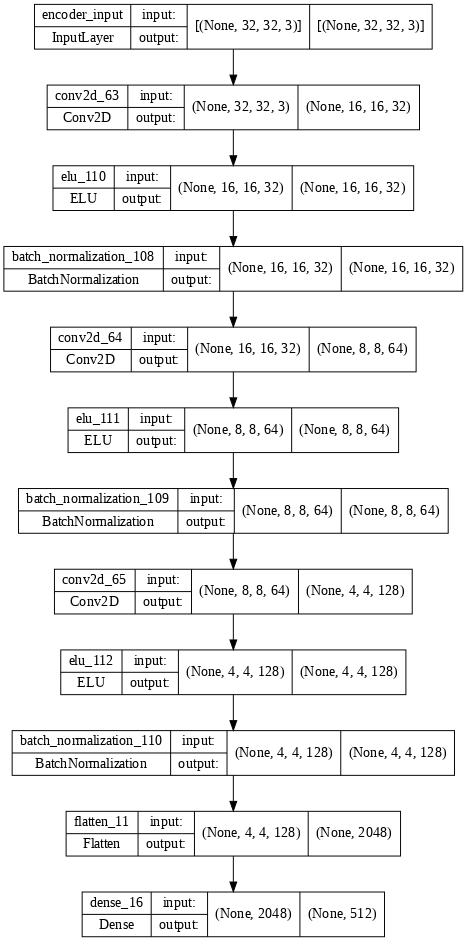

In [ ]:
tf.keras.utils.plot_model(
    encoder,
    show_shapes=True,
    show_layer_names=True,
    dpi=70,
)


After the reshape of the Dense into a 4x4x256, we can augment the image into the original shape to have the desired output with the transposed of the convolution, that is the Deconvolution, with the extracted features. 

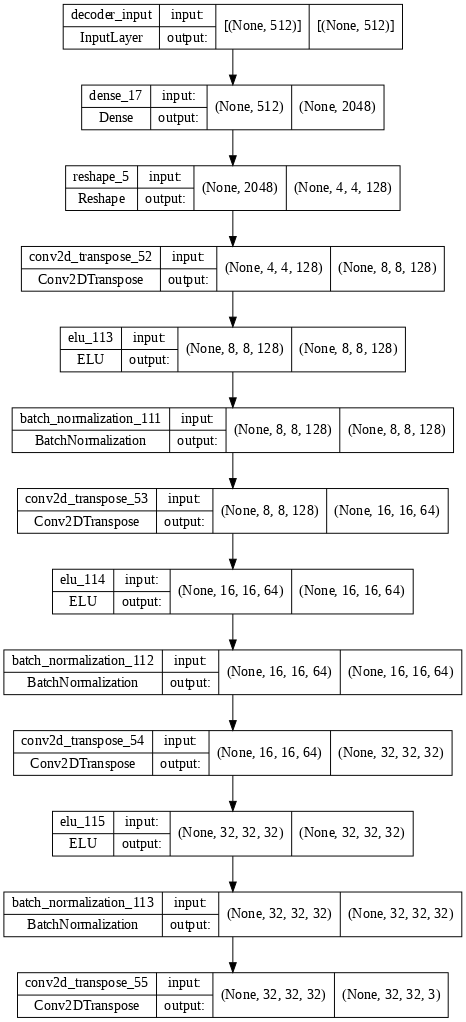

In [ ]:
tf.keras.utils.plot_model(
    decoder,
    show_shapes=True,
    expand_nested=False,
    dpi=70,
)

And now we can take a look to the complete model  (encoder and decoder layers are syntetized here)

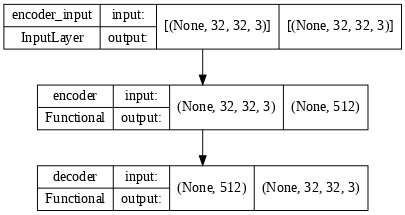

In [ ]:
tf.keras.utils.plot_model(
    autoencoder,
    show_shapes=True,
    show_layer_names=True,
    dpi=70,
)

From the summary function, autoencoder has:

*   Total params: 2,435,459
*   Trainable params: 2,434,563
*   Non-trainable params: 896


Now, let's **feed the data** into the model.

In [ ]:
history = autoencoder.fit(X_train,
                        y_train,
                        validation_data=(X_val,y_val),
                        epochs=50,
                        batch_size=128,
                        callbacks = [lr_reducer])

Epoch 1/50
1149/1149 [==============================] - 39s 26ms/step - loss: 0.0087 - acc: 0.7149 - val_loss: 0.0054 - val_acc: 0.7714 - lr: 0.0010
Epoch 2/50
1149/1149 [==============================] - 22s 19ms/step - loss: 0.0057 - acc: 0.7597 - val_loss: 0.0046 - val_acc: 0.8046 - lr: 0.0010
Epoch 3/50
1149/1149 [==============================] - 22s 19ms/step - loss: 0.0049 - acc: 0.7712 - val_loss: 0.0045 - val_acc: 0.7812 - lr: 0.0010
Epoch 4/50
1149/1149 [==============================] - 22s 19ms/step - loss: 0.0044 - acc: 0.7793 - val_loss: 0.0040 - val_acc: 0.8231 - lr: 0.0010
Epoch 5/50
1149/1149 [==============================] - 22s 19ms/step - loss: 0.0041 - acc: 0.7860 - val_loss: 0.0038 - val_acc: 0.8202 - lr: 0.0010
Epoch 6/50
1149/1149 [==============================] - 22s 19ms/step - loss: 0.0039 - acc: 0.7936 - val_loss: 0.0036 - val_acc: 0.8014 - lr: 0.0010
Epoch 7/50
1149/1149 [==============================] - 22s 19ms/step - loss: 0.0036 - acc: 0.8022 - val_l

####**Autoencoder Evaluation**

The MSE values are not so far from the zero, the minimum is reached at 0.0026 of MSE and until the 30/50 epochs the model is able to fit well the data in more or less 10 minutes, the other epochs are superflous and avoidable. The two losses are perfectly converging, this suggests a good behaviour and robustness of the model.

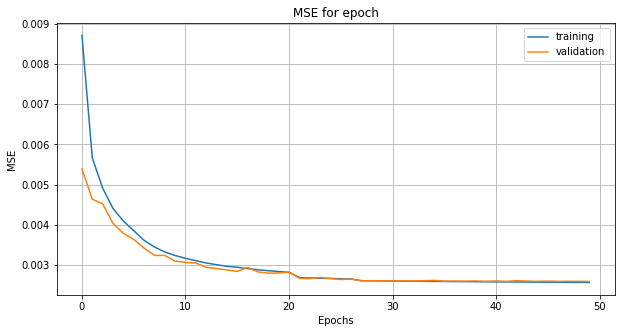

In [ ]:
plot_metrics(history, 'loss','val_loss',
             'MSE for epoch', 'Epochs', 
             'MSE', ['training', 'validation'])

Also the accuracy increases for both the datas, but there is something strange.

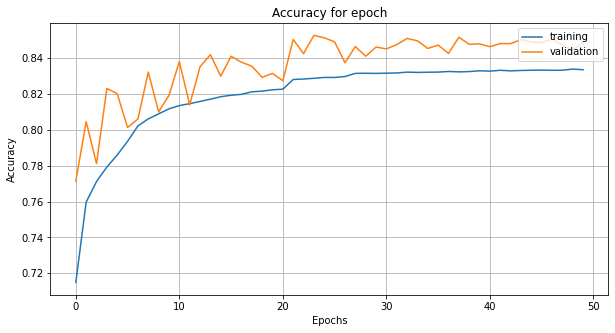

In [ ]:
plot_metrics(history, 'acc','val_acc',
             'Accuracy for epoch', 'Epochs', 
             'Accuracy', ['training', 'validation'])

Even if the results are not so bad, in general when the model trains over 0.0026 it tends to overfit. Learning rate callback and data augmentation were useful to avoid the overfitting scenario. What about the predictions ? From the accuracy, we can see that the validation accuracy increases with the training one, reaching a peak of 83%, that is a good value. But the accuracy suggests a strange case because it is slightly higher then the training one; it is possible that the validation set consists of "easier" examples than the training one. 

####**Autoencoder results** 

Let's **generate** the predictions!

In [ ]:
predictions_autoencoder = autoencoder.predict(X_test)

And **show** the desired results

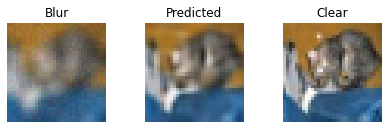

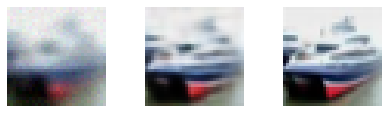

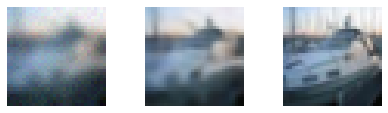

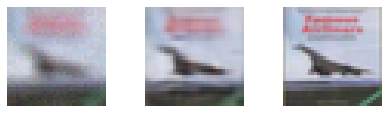

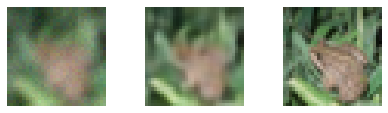

In [ ]:
for i in range(0,5):
  plot_results(X_test[i],predictions_autoencoder[i],y_test[i], i)

Convolutional autoencoder model is able to extract high level features in a good time, but the predicted results deserve too many noise anymore. Also, the accuracy is not so reassuring. We can do better with the second and principal model.

### ***REDNET, A CONVOLUTIONAL AUTOENCODER WITH RESIDUALS***

REDNET (Residual Encoder-Decoder Network) is also a neural autoencoder architecture  and it is very popular for image deblurring tasks, but what change here is that we deal with residuals. Here the samples are not reduced in terms of dimensions, otherwise it looses in terms of reconstructed details.Convolutional (green blocks) and Deconvolutional (yellow blocks) layers are symmetric, from convolution we extract the features and perform denoising, in deconvolution the details are recovered. The  idea is that the output of a convolutional layer is directly pointing to the corresponding deconvolutional layer, forwardly and backwardly. 

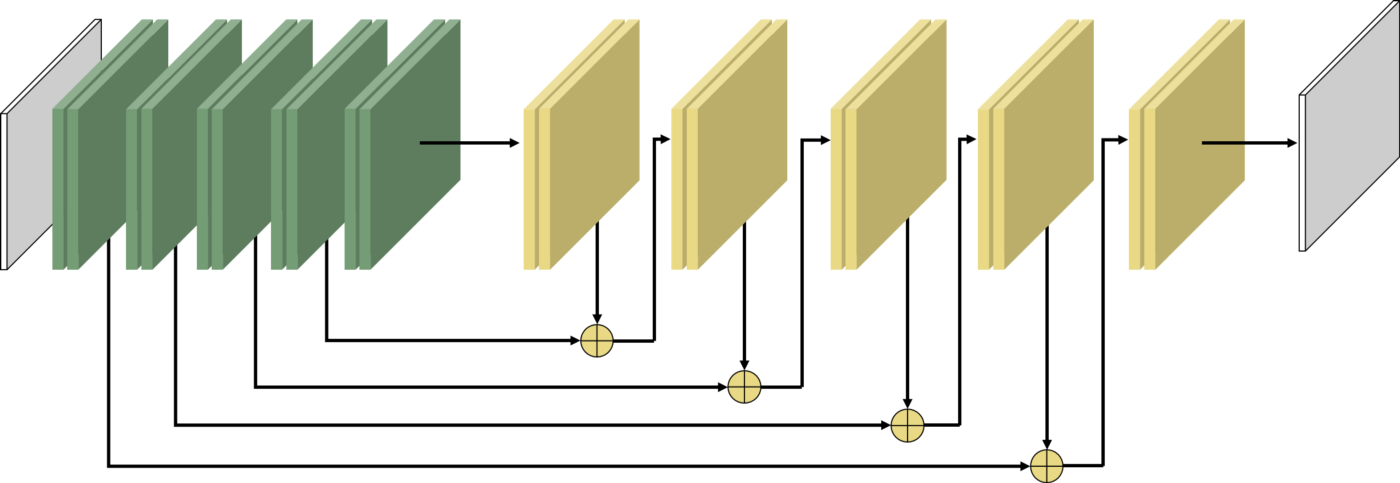

*Here the implementation of the ***encoder***, as a stack of 15 Convolution, batch normalization and ELU activation function*. Here we keep all the encoder layers because we need them in decoder functions. It is similar to the previous structure, but here the filter dimension is fixed and stride is 1 in order to have the very same dimension in each convolutional output.




In [ ]:
def red_encoder(in_layer, num_layers = 15):
  
    layers = list()
    x = in_layer

    for i in range(num_layers):
        x = Conv2D(filters=filter_dim[1],
                   kernel_size=3,
                   strides=1,
                   padding='same',
                   kernel_initializer="random_normal")(x)

        x = ELU()(x)
        x = BatchNormalization()(x)

        layers.append(x)


    return layers

Now we have the symmetric **decoder**, symilar in structure but involving the add operation, so we connect the Deconvolutional layers with the already collected Convolutional ones. In RedNET there is no reshape of the image sizes, the **stride** parameter is set to 1 indeed.

In [ ]:
def red_decoder(enc_layers, num_layers = 15):
  
    x = enc_layers[0]
    for i in range(num_layers):
        x = Conv2DTranspose(filters=filter_dim[1],
                   kernel_size=3,
                   strides=1,
                   padding='same',
                   kernel_initializer="random_normal")(x)
      
        if i % 2 != 0 :
          x = Add()([x, enc_layers[i]])

      
        x = ELU()(x)
        x = BatchNormalization()(x)
    
    return x

Tuning the **num_layers** parameter, we can define a RedNET of arbitrary layers, even if the best configuration is reached with 30 total layers, 15 of convolutions and 15 of deconvolutions. In this case, the propagation between the layers is done only every two steps of convolution, in order to avoid the vanishing gradient (alternatively, the bootleneck is at 0.0068). Because of we are dealing with Gaussian noise, the kernel used for the convolution is a **random_normal**, so it is tuned for normal distributions. Due to the tests the activation function used here is **ELU** because it performs better and make the training phase more robust and less floating than ReLU or LeakyReLU, so there are probably many negative inputs that influence negatively the weighting process. Also the output activation function here is ELU, since the sigmoid was less stable.

In [ ]:
def build_rednet():

  #ENCODER
  inputs = Input(shape = input_shape, name = 'encoder_input')
  encoded_layers = red_encoder(inputs)
  encoded_layers.reverse()
  #DECODER
  decode_layers = red_decoder(encoded_layers)
  #OUTPUT
  output = Conv2DTranspose(filters=3,
                            kernel_size=1,
                            strides=1,
                            padding='same',
                          kernel_initializer="random_normal")(decode_layers)

  output = Add()([output, inputs])
  output = ELU()(output)
  rednet = Model(inputs=inputs, outputs=output)
  rednet.compile(optimizer="adam", loss="mse",metrics=["acc"])

  return rednet

Let's **instantiate** the model , here is much important to use the TPU in order to minimize crucially the computational time. 

In [ ]:
try:
  with strategy.scope():
    rednet = build_rednet()
    print('TPU training enabled')
except:
  rednet = build_rednet()
  print('GPU training enabled')

TPU training enabled


**We can already plot the model in order to check the correctness of the layers, the correctness of input and output space and if is there any disconnection.**

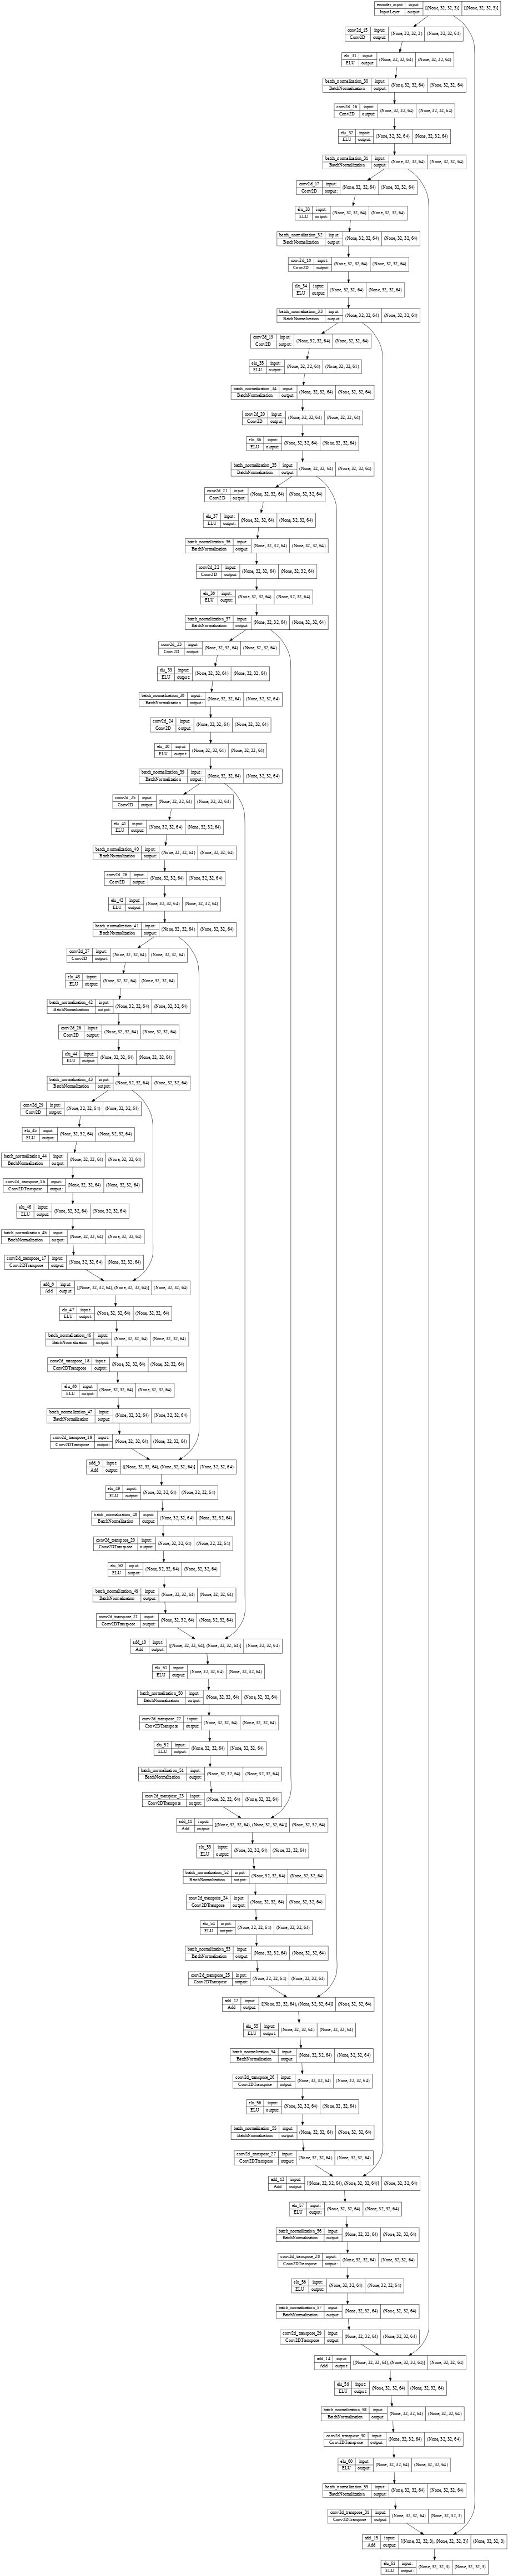

In [ ]:
tf.keras.utils.plot_model(
    rednet,
    show_shapes=True,
    show_layer_names=True,
    dpi=40,
)

Since i have augmented the data, the batch size for this model can be a bit bigger, in order to reduce the computational time. Here i set 50 epochs, but we will see that they are too much. From the summary function, RedNET has: 

*   Total params: 1,080,579
*   Trainable params: 1,076,739
*   Non-trainable params: 3,840

Now, **let's feed data** into RedNET.

In [ ]:
history_red = rednet.fit(X_train,
                      y_train,
                      validation_data=(X_val,y_val),
                      epochs=50, 
                      batch_size=256,
                      callbacks = [lr_reducer])

Epoch 1/50
575/575 [==============================] - 82s 97ms/step - loss: 0.0049 - acc: 0.7747 - val_loss: 0.0038 - val_acc: 0.7963 - lr: 0.0010
Epoch 2/50
575/575 [==============================] - 37s 64ms/step - loss: 0.0027 - acc: 0.8229 - val_loss: 0.0026 - val_acc: 0.8315 - lr: 0.0010
Epoch 3/50
575/575 [==============================] - 37s 65ms/step - loss: 0.0025 - acc: 0.8337 - val_loss: 0.0024 - val_acc: 0.8423 - lr: 0.0010
Epoch 4/50
575/575 [==============================] - 37s 65ms/step - loss: 0.0024 - acc: 0.8387 - val_loss: 0.0024 - val_acc: 0.8405 - lr: 0.0010
Epoch 5/50
575/575 [==============================] - 37s 65ms/step - loss: 0.0023 - acc: 0.8420 - val_loss: 0.0023 - val_acc: 0.8448 - lr: 0.0010
Epoch 6/50
575/575 [==============================] - 37s 65ms/step - loss: 0.0023 - acc: 0.8455 - val_loss: 0.0022 - val_acc: 0.8472 - lr: 0.0010
Epoch 7/50
575/575 [==============================] - 37s 65ms/step - loss: 0.0022 - acc: 0.8481 - val_loss: 0.0022 - 

####***RedNET evaluation***

RedNET seems to be very powerful with respect to the simple autoencoder, it can reach the very same loss values in only 3 epochs. Even if without data augmentation and the learning rate callback is much less robust and more floating, with this configuration it is surely the best between the two models for such task. It reaches good results in just 20 epochs, with two perfectly converging losses. Therefore, the best mse value is reached at the 40/50 epoch, with 0.0019 and more or less 28 minutes of training time (21 minutes if we stop at 40 epoch). The other epochs are superfluous and avoidable. Let's take a look to the metric graphs. 

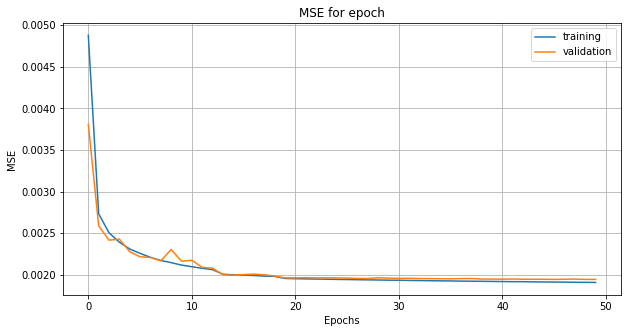

In [ ]:
plot_metrics(history_red, 'loss','val_loss',
             'MSE for epoch', 'Epochs', 
             'MSE', ['training', 'validation'])

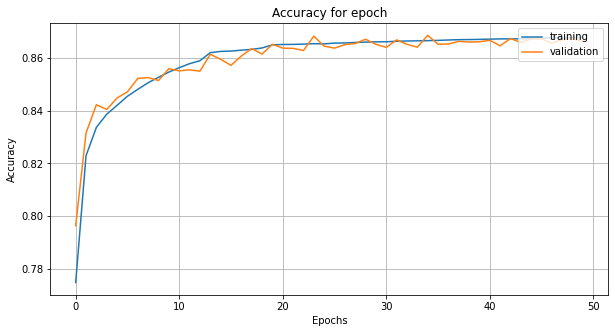

In [ ]:
plot_metrics(history_red, 'acc','val_acc',
             'Accuracy for epoch', 'Epochs', 
             'Accuracy', ['training', 'validation'])

RedNET losses are very good, we can see that they are directly proportional in decreasing trend, we can assert that such model is able to fit perfectly the datas and it doen not encount with any overfitting or underfitting scenarios, reaching an accuracy of the 87%. Therefore, the accuracy is now valid.

####**RenNET results**

We can now use the weighted model to predict the test values...

In [ ]:
predictions_rednet = rednet.predict(X_test)

...and plot the resulting predictions

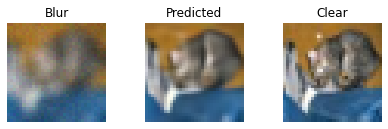

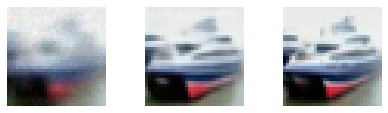

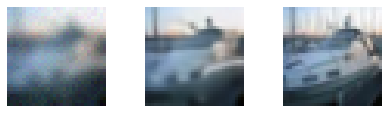

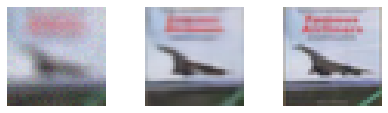

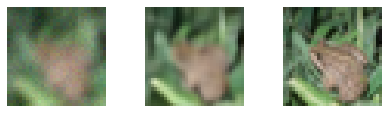

In [ ]:
for i in range(0,5):
  plot_results(X_test[i],predictions_rednet[i],y_test[i],i)

###**Conclusions**

RedNET is a very powerful model that is able to solve the task with good results. Its limit is only concerned about the computational effort, especially if we deploy data augmentation to prevent the overfitting. However, with a good tuning and the help of TPU, we can minimize a lot the computational time. Otherwise, the simple autoencoder is simpler and needs a simple GPU, but the results, both numerical and visual , are worse. Here a little tabular representation to compare the performances. 

In [ ]:
from tabulate import tabulate
table = [['AUTOENCODER MSE', '% AUTOENCODER ACCURACY', 'REDNET MSE','% REDNET ACCURACY'],
         [history.history['loss'] [-1], round((history.history['acc'] [-1]*100))
         ,history_red.history['loss'][-1],round((history_red.history['acc'][-1])*100)]]
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

╒═══════════════════╤══════════════════════════╤══════════════╤═════════════════════╕
│   AUTOENCODER MSE │   % AUTOENCODER ACCURACY │   REDNET MSE │   % REDNET ACCURACY │
╞═══════════════════╪══════════════════════════╪══════════════╪═════════════════════╡
│        0.00256731 │                       83 │   0.00190713 │                  87 │
╘═══════════════════╧══════════════════════════╧══════════════╧═════════════════════╛
